In [1]:
# imports 

# make notebook span full width of window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] + "Dragonfly44_SFH/" # hack, but works

import numpy as np
from Dragonfly44_SFH.utils import plotting

In [2]:
result_params = {}

from Dragonfly44_SFH.fitting.output.fits.fits_DF44_summary import *
from Dragonfly44_SFH.utils import prospect_io

path_fits = path_base+ "fitting/output/fits/"

path_data = path_base+ "data/"
file_data = path_data+"DF44/obs_phot_specKCWI_sigma110.h5"

for key, result_file, label in [ 
#                            ['aD02', fit_aD02_phot,'alphaD = 0.2'],
                           ['aD03', fit_aD03_phot,'alphaD = 0.3'],
                           ['aD05', fit_aD05_phot,'alphaD = 0.5'],
                           ['aD1', fit_aD1_phot,'alphaD = 1'],
                           ['csfrcont', fit_csfrcont_phot, 'cSFR continuity']
                          ]:

    result, obs, model = prospect_io.read_results( path_fits+ result_file, file_data=file_data )

    result_params[key] = dict( result=result, obs=obs, model=model, label=label )

zobs = float(model.params['zred'])

In [3]:
# showkeys = ['aD02','aD03','aD05','aD1','csfrcont']
showkeys = ['aD03','aD05','aD1','csfrcont']


In [4]:
# CHECK if each fit provided a spectrum with rough specphot calibration
# e.g. fit_aD05_phot_specKCWI includes a spectrum with normalization = 1e-8
# other fits used normalization = 1, relying entirely on spectro-photometric calibration polynomial
# for consistency, remove the normalization term!
# this is an annoying inconsistency of this project...
specnorm = 1e-8

for key in showkeys:
    if result_params[key]['obs']['spectrum'] is None: continue # skip if phot-only fit
        
    specnorm_in_fit = np.median( result_params[key]['obs']['spectrum'] )
    if specnorm_in_fit < 1e-3: # somewhat arbitrary threshold
        
        result_params[key]['obs']['spectrum'] /= specnorm 
        result_params[key]['obs']['unc'] /= specnorm 

        result_params[key]['result']['bestfit']['spectrum'] /= specnorm 
        result_params[key]['result']['bestfit']['speccal'] /= specnorm 
        
        if 'draws' in result_params[key]['result']: # post-processing step not always done
            result_params[key]['result']['draws']['bestfit']['spectrum'] /= specnorm 
            result_params[key]['result']['draws']['bestfit']['speccal'] /= specnorm 

In [5]:
# setup styling

markers = ['o','s','X','v']
colors = ['orange','m','lime','c']

for i,key in enumerate( result_params.keys() ):
    result_params[key]['obs_params'] = {'marker':'D', 'color':'k', 'ms':12}
    result_params[key]['posts_params'] = {'color':colors[i]}
    result_params[key]['bestfit_params'] = {'color':colors[i], 'marker':markers[i]}



## plot SED

alphaD = 0.3 Bestfit $\chi^2$/N$_\mathrm{phot}$=1.69
alphaD = 0.5 Bestfit $\chi^2$/N$_\mathrm{phot}$=0.61
alphaD = 1 Bestfit $\chi^2$/N$_\mathrm{phot}$=0.62
  draws not in file
cSFR continuity Bestfit $\chi^2$/N$_\mathrm{phot}$=0.59


<ipython-input-16-56065925a249>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels( axes[1].get_xticks( ) )


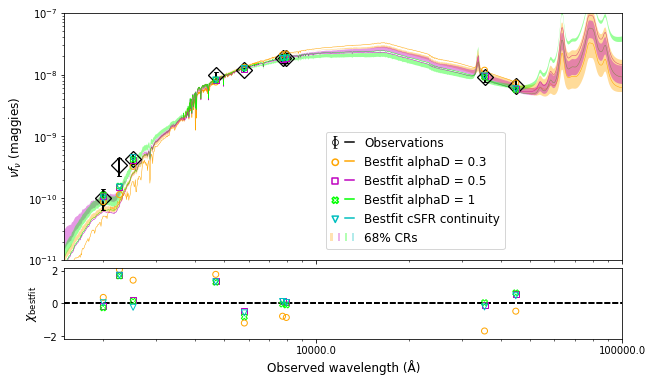

In [16]:
params_base = dict( return_fig=True, zobs=0, figsize=(10,12), show_chi2s=False )

fig = None
for key in showkeys:
    fig = plotting.plot_obs_and_fits( **result_params[key], fig=fig, **params_base )

if True: # add legend
    ax_legend = fig.get_axes()[0]

    handles, handles_CRs = [],[]
    labels = []
    for i,key in enumerate( showkeys ):
        pp = result_params[key]
        
        if i==0: # add handles for observations    
            ha = ax_legend.errorbar([-1],[-1], yerr=[1], 
                                     color=pp['obs_params']['color'], mec=pp['obs_params']['color'], 
                                     mfc='None', fmt=' ', capsize=2, ms=12, marker='o', mew=0.7)
            hb, = ax_legend.plot([],[], color=pp['obs_params']['color'])
            handles.append( (ha,hb) )
            labels.append('Observations')
        
        
            
        ha = ax_legend.scatter([],[], 
                               edgecolor=pp['bestfit_params']['color'], facecolor='None', 
                               marker=pp['bestfit_params']['marker'], zorder=2, s=160, lw=1.5, )
        hb, = ax_legend.plot([],[], color=pp['bestfit_params']['color'])
        handles.append( (ha,hb) )
        if 'label' in pp.keys(): l = pp['label']
        elif 'label' in pp['bestfit_params'].keys(): pp['bestfit_params']['label']
        else: l = i+1
        labels.append('Bestfit {}'.format( l ))
        
        h = ax_legend.fill_between([],[], 
                                   lw=0, color=pp['bestfit_params']['color'], alpha=0.3)
        handles_CRs.append( h )
        
    handles.append( tuple(handles_CRs) )
    labels.append( "68% CRs" )
     
    from matplotlib.legend_handler import HandlerTuple
    ax_legend.legend( handles, labels,
                      numpoints=1, loc=4, markerscale=0.5, bbox_to_anchor=[0.8,0.02],
                      handler_map={tuple: HandlerTuple(ndivide=None)},
                    )

axes = fig.get_axes()    
[ ax.set_xlim( 1500,1e5 ) for ax in axes ]
axes[0].set_ylim( 1e-11,1e-7 ) 
axes[1].set_xticklabels( axes[1].get_xticks( ) )

plt.show()

## plot corner plot

In [21]:
par_settings = {
                'dust2':{'label':r"$\hat{\tau}_\mathrm{dust,~diffuse}$", 
                         'bin_range':[0,1]},
                'logzsol':{'label':r"$\log(~Z_\ast/\mathrm{Z}_\odot~)$", 
                           'bin_range':[-2,0.2]},
                'logmass':{'label':r"*$\log(~M_{\ast,~\mathrm{total}}/\mathrm{M}_\odot~)$", 
                           'bin_range':[7,9]},
                'logmass_stellar':{'label':r"*$\log(~M_{\ast}/\mathrm{M}_\odot~)$", 
                                   'bin_range':[7,8.5]},
                "mwa":{'label':r"*$t_\mathrm{mass}$ (Gyr)", 
                       'bin_range':[0,13.5]},
                }

showpars = ['dust2','logzsol','logmass',
#             'logmass_stellar', # missing from some outputs (requires post-processing)
            "mwa"]


In [28]:
from Dragonfly44_SFH.utils.transforms import chain_to_param
from Dragonfly44_SFH.utils.misc_utils import weighted_quantile

for par in showpars:
    for key in showkeys:
        result = result_params[key]['result']
        x = chain_to_param( param=par, **result )
        w = result['weights']
        qnts = weighted_quantile( np.squeeze(x), quantiles=[0.16,0.5,0.84], sample_weight=w )
        print( '{:12}\t{} = {}'.format( key, par, qnts ) )
    print()

aD03        	dust2 = [0.21362688 0.31999334 0.45570475]
aD05        	dust2 = [0.24762895 0.34671682 0.48089503]
aD1         	dust2 = [0.25955264 0.35993294 0.49048917]
csfrcont    	dust2 = [0.18479009 0.30874532 0.46045353]

aD03        	logzsol = [-1.77135059 -1.41198307 -0.94397078]
aD05        	logzsol = [-1.80788096 -1.4572327  -1.02593986]
aD1         	logzsol = [-1.78717844 -1.45662169 -0.9842414 ]
csfrcont    	logzsol = [-1.77413232 -1.40055371 -0.8077306 ]

aD03        	logmass = [8.12402557 8.24079743 8.35730242]
aD05        	logmass = [8.11275748 8.2278593  8.31985662]
aD1         	logmass = [8.1388161  8.22230788 8.3042312 ]
csfrcont    	logmass = [7.99095363 8.21565494 8.42321985]

aD03        	mwa = [5.01402902 6.67014    8.35827697]
aD05        	mwa = [5.14104911 6.62806595 8.15146597]
aD1         	mwa = [5.65343254 6.78475423 7.82171015]
csfrcont    	mwa = [4.00026133 6.26563645 9.01541746]



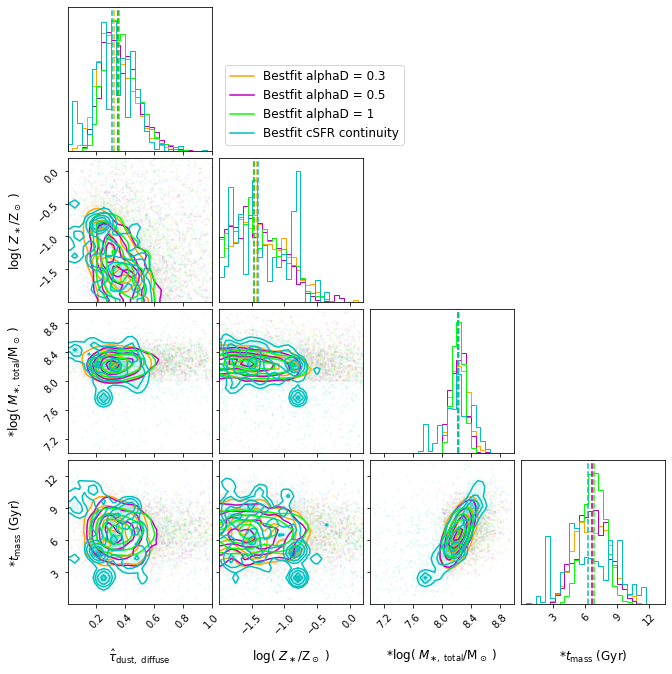

In [22]:
labels = [ par_settings[p]['label'] for p in showpars ]
bin_ranges = [ par_settings[p]['bin_range'] for p in showpars ]

xparams = dict( labels=labels, smooth=1, range=bin_ranges )
params_base = dict( showpars=showpars, smooth=1, show_titles=1, labels=labels, return_fig=1, xparams=xparams )

fig = None
for key in showkeys:
    fig = plotting.plot_corner( result=result_params[key]['result'], color=result_params[key]['posts_params']['color'], 
                                fig=fig, **params_base )
    
if True: # add legend
    ax_legend = fig.get_axes()[1]

    handles, labels = [],[]
    for i,key in enumerate( showkeys ):
        pp = result_params[key]
        h, = ax_legend.plot([],[], color=pp['bestfit_params']['color'])
        handles.append( h )
        if 'label' in pp.keys(): l = pp['label']
        elif 'label' in pp['bestfit_params'].keys(): pp['bestfit_params']['label']
        else: l = i+1
        labels.append('Bestfit {}'.format( l ))
     
    ax_legend.legend( handles, labels, loc=3 )    


## plot reconstructed SFH

In [6]:
# sample from prior

# size = int(1e2) # better to have more draws, but takes longer
size = -1 # skip

for key in showkeys:
    if size>0:
        prior_draws = prospect_io.get_sfh_priors( result_params[key]['model'], size )
    else:
        prior_draws = None
    result_params[key]['prior_draws'] = prior_draws


In [7]:
# setup styling

hatches = ['//','\\','////','||||']

for i,key in enumerate( result_params.keys() ):
    result_params[key]['obs_params'] = {'marker':'D', 'color':'k', 'ms':12}
    result_params[key]['posts_params'] = {'color':colors[i]}
    result_params[key]['bestfit_params'] = {'lw':1, 'edgecolor':colors[i], 'facecolor':'None', 
                                            'marker':markers[i], 's':160 }
    result_params[key]['priors_params'] = {'facecolor':'None', 'edgecolor':colors[i], 'hatch':hatches[i], 'lw':0 }



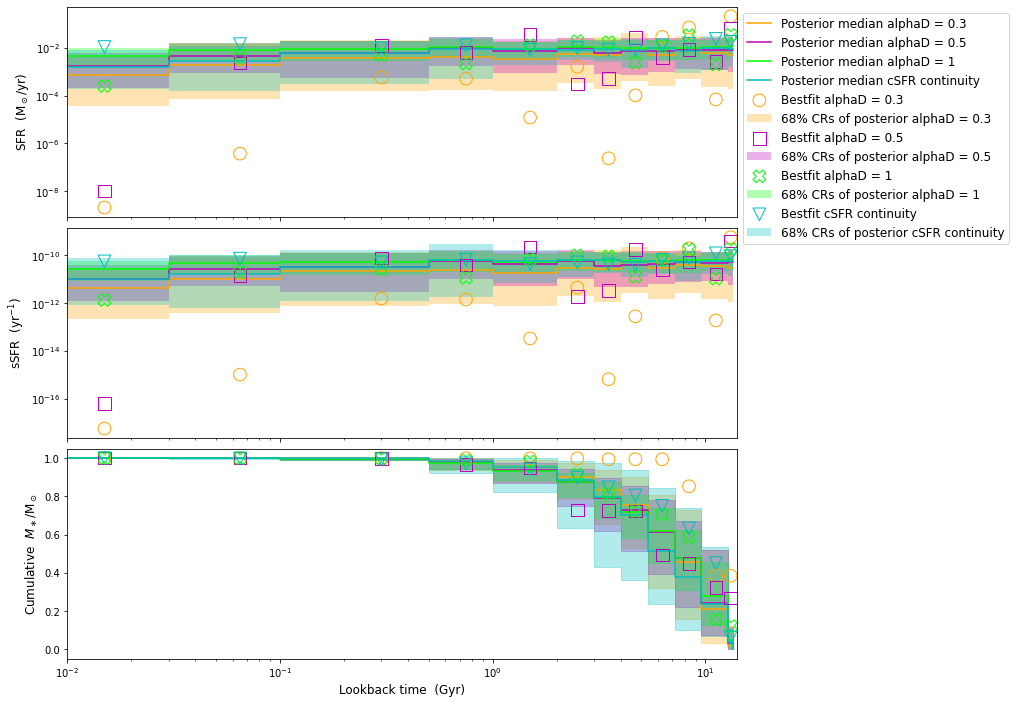

In [8]:
fig, axes = plt.subplots(3,1, figsize=(12,12), sharex=True)
fig.subplots_adjust( wspace=0.05, hspace=0.05 )        
ax_sfr,ax_ssfr,ax_cmf = axes.flatten()

for key in showkeys:
    pp = result_params[key]

    plotting.plot_sfh( ax_sfr, norm_by_mass=False, **pp )
    plotting.plot_sfh( ax_ssfr, norm_by_mass=True, **pp )
    plotting.plot_cmf( ax_cmf, xscale='linear', style='step', **pp )

[ ax.set_xlabel(None) for ax in axes[:-1]]
ax_sfr.legend( loc=2, bbox_to_anchor=[1,1])
ax_sfr.set_xscale('log')
ax_sfr.set_xlim(0.01, 14)
plt.show()